## Importations et chargement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import util
import pyfpgrowth
import re
csv_path = 'data/CES19.csv'

In [2]:
df = pd.read_csv(csv_path)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (25,27,28,30,31,33,34,39,179,181,188,192,193,199,210,227,234,236,237,239,240,243,276,299,302,311,314,315,316,327,362,417,418,421,422,423,424,425,431,464,465,468,538,541,578,579,582,583,584) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,cps19_StartDate,cps19_EndDate,cps19_ResponseId,cps19_consent,cps19_citizenship,cps19_yob,cps19_yob_2001_age,cps19_gender,cps19_province,...,split_vol_assoc,pes19_data_quality,pes19_panel,pes19_age,pes19_duplicates_flag,pes19_inattentive,cps19_weight_general_all,cps19_weight_general_restricted,pes19_weight_general_all,pes19_weight_general_restricted
0,1,2019-09-13 04:09:44,2019-09-13 04:36:19,R_1OpYXEFGzHRUpjM,I consent to participate in this study. I have...,Canadian citizen,1989,NaN,A woman,Quebec,...,NaN,NaN,NaN,NaN,NaN,NaN,0.681336,0.673652,NaN,NaN
1,2,2019-09-13 04:39:09,2019-09-13 04:57:06,R_2qdrL3J618rxYW0,I consent to participate in this study. I have...,Canadian citizen,1998,NaN,A woman,Quebec,...,NaN,NaN,NaN,NaN,NaN,NaN,0.681336,0.673652,NaN,NaN
2,3,2019-09-13 06:01:19,2019-09-13 06:27:29,R_USWDAPcQEQiMmNb,I consent to participate in this study. I have...,Canadian citizen,2000,NaN,A woman,Ontario,...,NaN,NaN,NaN,NaN,NaN,NaN,0.650459,0.635656,NaN,NaN
3,4,2019-09-13 06:05:37,2019-09-13 06:50:53,R_3IQaeDXy0tBzEry,I consent to participate in this study. I have...,Canadian citizen,1998,NaN,A man,Ontario,...,NaN,NaN,NaN,NaN,NaN,NaN,0.887253,0.856576,NaN,NaN
4,5,2019-09-13 06:05:52,2019-09-13 06:32:53,R_27WeMQ1asip2cMD,I consent to participate in this study. I have...,Canadian citizen,2000,NaN,A woman,Ontario,...,NaN,NaN,NaN,NaN,NaN,NaN,1.653808,1.651144,NaN,NaN


### Enlever les colonnes ayant plus de 125 réponses uniques

In [3]:
unique_answers_max = 125
columns_with_too_many_unique_answers = util.get_unique_values_per_column(df, min_unique_threshold=unique_answers_max)

print(f"\nIl y a {len(columns_with_too_many_unique_answers)} colonnes avec trop de réponses uniques.\n")

# Create another df without those columns
df_trimmed = df.loc[:, [column not in columns_with_too_many_unique_answers for column in df.columns]]


Il y a 48 colonnes avec trop de réponses uniques.



### Enlever les colonnes ayant 0 ou 1 réponse unique

In [4]:
unique_answers_min = 2
columns_without_enough_unique_answers = util.get_unique_values_per_column(df, max_unique_threshold=unique_answers_min)

print(f"\nIl y a {len(columns_without_enough_unique_answers)} colonnes avec trop peu de réponses uniques.\n")

# Create another df without those columns
df_trimmed = df_trimmed.loc[:, [column not in columns_without_enough_unique_answers for column in df_trimmed.columns]]


Il y a 137 colonnes avec trop peu de réponses uniques.



### Enlever les questions jugées non-pertinentes

In [5]:
non_pertinent_columns = [
    "cps19_consent", # La question de consentement à répondre avant de commencer le questionnaire
    
]

print(f"\nIl y a {len(non_pertinent_columns)} colonnes non pertinentes.\n")

df_trimmed = df_trimmed.loc[:, [column not in non_pertinent_columns for column in df_trimmed.columns]]

df_trimmed.head()


Il y a 1 colonnes non pertinentes.



,cps19_citizenship,cps19_yob,cps19_gender,cps19_province,cps19_education,cps19_demsat,cps19_imp_iss_party,cps19_imp_loc_iss_p,cps19_interest_gen_1,cps19_interest_elxn_1,...,split_health_followups,split_gender_id,split_big5,split_hatespeech,split_vol_assoc,pes19_data_quality,pes19_panel,pes19_age,pes19_duplicates_flag,pes19_inattentive
0,Canadian citizen,1989,A woman,Quebec,Master's degree,Fairly satisfied,Green Party,ndp,9.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Canadian citizen,1998,A woman,Quebec,Master's degree,Don't know/ Prefer not to answer,Green Party,ndp,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Canadian citizen,2000,A woman,Ontario,Some university,Fairly satisfied,NaN,NaN,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Canadian citizen,1998,A man,Ontario,Some university,Fairly satisfied,Conservative Party,NaN,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Canadian citizen,2000,A woman,Ontario,Completed secondary/ high school,Fairly satisfied,Don't know/ Prefer not to answer,Conservative Party,8.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Trouver les questions à choix multiples non étalées sur plusieurs questions

In [6]:
multiple_choice_question_keywords = ["Very satisfied", "None of these", "Got better", "Fewer immigrants", "Fewer refugees", "Not at all well", "Very opposed", "Fairly strongly", "Some of the time", "Much closer", "A good job", "None at all", "Very comfortable", "Extremely easy", "Weekly", "Sometimes", "Just once", "Much more"]
#print(get_columns_per_value_keyword("Very satisfied"))

# Questions à 7 choix
six_choice_questions = ['pes10_socnet3']
print(f"Il y a {len(six_choice_questions)} questions à 7 choix.")

# Questions à 6 choix
six_choice_questions = ['pes19_keepromises', 'pes19_tieus', 'pes19_tiechina', 'pes19_emb_info', 'pes19_donerm', 'pes19_donew', 'pes19_donegl', 'pes19_doneqc', 'pes19_taxes_1', 'pes19_taxes_2', 'pes19_taxes_3', 'pes19_taxes_4', 'pes19_taxes_5', 'pes19_gap']
print(f"Il y a {len(six_choice_questions)} questions à 6 choix.")

# Questions à 5 choix
five_choice_questions = ['cps19_demsat', 'cps19_fed_gov_sat', 'cps19_prov_gov_sat', 'pes19_dem_sat', 'pes19_emb_satif', "cps19_rel_imp", 'cps19_pos_fptp', 'cps19_pos_life', 'cps19_pos_cannabis', 'cps19_pos_carbon', 'cps19_pos_energy', 'cps19_pos_envreg', 'cps19_pos_jobs', 'cps19_pos_subsid', 'cps19_pos_trade', 'cps19_govt_confusing', 'cps19_govt_say', 'cps19_pol_eth', 'cps19_lib_promises', 'pes19_pos_fptp', 'pes19_paymed', 'pes19_senate', 'pes19_envirojob', 'pes19_hatespeech', 'pes19_losetouch', 'pes19_womenhome', 'pes19_govtcare', 'pes19_complicated', 'pes19_famvalues', 'pes19_pollie', 'pes19_bilingualism', 'pes19_equalrights', 'pes19_ethid', 'pes19_fitin', 'pes19_immigjobs', 'pes19_govteff', 'pes19_govtprograms', 'pes19_emb_none', 'pes19_emb_id', 'pes19_emb_vote16', 'pes19_lowturnout', 'pes19_internetvote1', 'pes19_mediaelite', 'pes19_medianolie', 'pes19_opinion', 'pes19_lookslikeme', 'pes19_womenparl', 'pes19_populism_1', 'pes19_populism_2', 'pes19_populism_3', 'pes19_populism_4', 'pes19_populism_5', 'pes19_populism_6', 'pes19_populism_7', 'pes19_populism_8', 'pes19_nativism1', 'pes19_nativism2', 'pes19_nativism3', 'pes19_nativism4', 'pes19_nativism5', 'pes19_canid1', 'pes19_canid2', 'pes19_canid3', 'pes19_sdo1', 'pes19_sdo2', 'pes19_sdo3', 'pes19_sdo4', 'pes19_abort3', 'pes19_abort6', 'pes19_trade', 'pes19_privjobs', 'pes19_govt_act_ineq', 'pes19_deserve1', 'pes19_deserve2', 'pes19_blame', 'pes19_hostile1', 'pes19_hostile2', 'pes19_hostile3', 'pes19_benevolent1', 'pes19_benevolent2', 'pes19_benevolent3', 'pes19_pos_carbon', 'pes19_pos_energy', 'pes19_newerlife', 'pes19_happy', 'pes19_satisfied', 'pes19_cognition', 'cps19_snclav', 'cps19_quebec_sov', 'pes19_ottawa_perf', 'pes19_conf_inst1_1', 'pes19_conf_inst1_2', 'pes19_conf_inst1_3', 'pes19_conf_inst2_1', 'pes19_conf_inst2_2', 'pes19_conf_inst2_3', 'pes19_conf_inst2_4', 'pes19_conf_inst2_5', 'pes19_conf_inst2_6', 'pes19_conf_inst2_7', 'pes19_conf_inst2_8', 'pes19_conf_inst2_9' 'pes19_internetregis', 'pes19_disagreed', 'pes19_affective_1', 'pes19_affective_2', 'pes19_affective_3', 'pes19_affective_4' 'cps19_volunteer', 'pes19_partic1_1', 'pes19_partic1_2', 'pes19_partic1_3', 'pes19_partic2_1', 'pes19_partic2_2', 'pes19_partic2_3', 'pes19_partic2_4', 'pes19_partic3_1', 'pes19_partic3_2', 'pes19_partic3_3', 'pes19_partic3_4', 'pes19_partic3_5', 'pes19_partic3_6']
print(f"Il y a {len(five_choice_questions)} questions à 5 choix.")

# Questions à 3 choix + Extra (Je ne sais pas/préfère ne pas répondre)
four_choice_questions = ['cps19_spend_educ', 'cps19_spend_env', 'cps19_spend_just_law', 'cps19_spend_defence', 'cps19_spend_imm_min' 'cps19_econ_retro', 'cps19_own_fin_retro', 'cps19_imm', 'cps19_refugees', 'cps19_fed_id_str', 'cps19_prov_id_str', 'pes19_pidtradstrong']
print(f"Il y a {len(four_choice_questions)} questions à 3 choix.")


Il y a 1 questions à 7 choix.
Il y a 14 questions à 6 choix.
Il y a 120 questions à 5 choix.
Il y a 11 questions à 3 choix.


Independent              11
Christian Heritage        5
PPC                       4
Undecided                 4
Independent candidate     4
                         ..
Still undecided           1
Rhinocerous Party         1
Declining my vote         1
Independant               1
Bloc Qu<e9>b<e9>cois      1
Name: cps19_votechoice_7_TEXT, Length: 140, dtype: int64


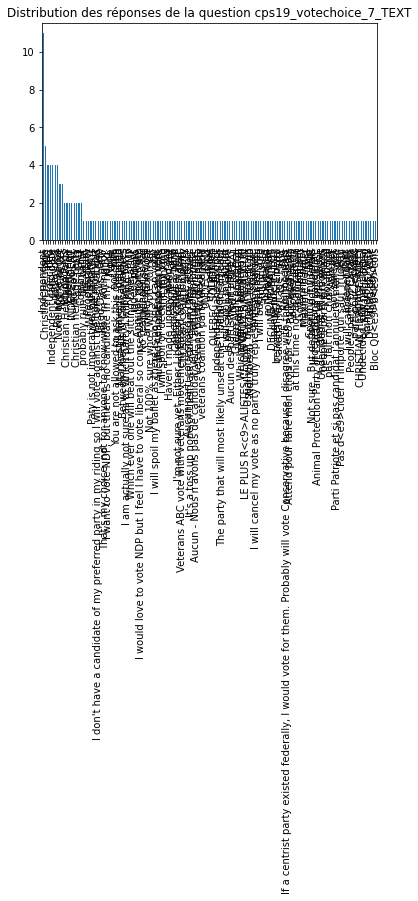

In [7]:
col_of_interest = "cps19_votechoice_7_TEXT"
print(df[col_of_interest].value_counts())
util.plot_column_values(df, col_of_interest)

### Isoler les questions "étiquette"

In [8]:
classes = [
    'Another party (please specify)',
    'Bloc Qu<e9>b<e9>cois',
    'Conservative Party',
    "Don't know/ Prefer not to answer",
    'Green Party',
    'Liberal Party',
    'ndp',
    "People's Party"
]

class_to_int_dic = {
    classes[0]: 0,
    classes[1]: 1,
    classes[2]: 2,
    classes[3]: 3,
    classes[4]: 4,
    classes[5]: 5,
    classes[6]: 6,
    classes[7]: 7
}

int_to_class_dic = {
    0: classes[0],
    1: classes[1],
    2: classes[2],
    3: classes[3],
    4: classes[4],
    5: classes[5],
    6: classes[6],
    7: classes[7],
}

id_column = "id"
label_column = "label"
label_questions = ['cps19_votechoice', 'cps19_votechoice_pr', 'cps19_vote_unlikely', 'cps19_vote_unlike_pr', 'cps19_v_advance']
label_detail_questions = ['cps19_votechoice_7_TEXT', 'cps19_votechoice_pr_7_TEXT', 'cps19_vote_unlikely_7_TEXT', 'cps19_vote_unlike_pr_7_TEXT', 'cps19_v_advance_7_TEXT', 'cps19_vote_lean', 'cps19_vote_lean_7_TEXT', 'cps19_vote_lean_pr', 'cps19_vote_lean_pr_7_TEXT', 'cps19_2nd_choice', 'cps19_2nd_choice_7_TEXT', 'cps19_2nd_choice_pr', 'cps19_2nd_choice_pr_7_TEXT', 'cps19_not_vote_for_1', 'cps19_not_vote_for_2', 'cps19_not_vote_for_3', 'cps19_not_vote_for_4', 'cps19_not_vote_for_5', 'cps19_not_vote_for_6', 'cps19_not_vote_for_7', 'cps19_not_vote_for_8', 'cps19_not_vote_for_9', 'cps19_not_vote_for_7_TEXT']

### Évaluation de l'équilibre des classes

{'Another party (please specify)': 217, 'Bloc Qu<e9>b<e9>cois': 1497, 'Conservative Party': 8875, "Don't know/ Prefer not to answer": 5141, 'Green Party': 2611, 'Liberal Party': 9374, 'ndp': 4559, "People's Party": 663}


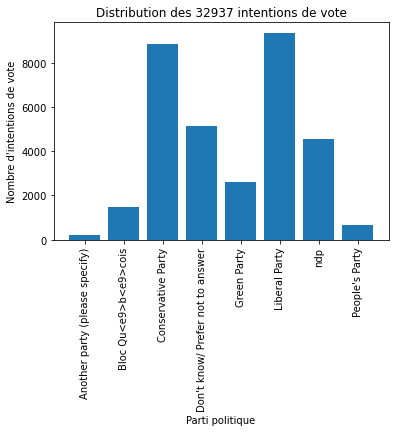

On remarque que les classes sont très débalancées. En effet, le parti libéral a 43x plus d'intentions de vote que l'option "Un autre parti".
Il y a également beaucoup de répondeurs incertains. À première réflexion, ils sont soit incertains entre deux partis politiquement près, ou bien il sont eux-mêmes politiquement loin de tous les partis (aucun parti ne ressemble assez à leurs préférences politiques)


In [9]:
label_count = {
    classes[0]: 0,
    classes[1]: 0,
    classes[2]: 0,
    classes[3]: 0,
    classes[4]: 0,
    classes[5]: 0,
    classes[6]: 0,
    classes[7]: 0
}


for question in label_questions:
    answers = util.get_column_value_counts(df, question)
    for label in label_count.keys():
        label_answers = answers.get(label)
        if label_answers is not None:
            label_count[label] += label_answers

print(label_count)

# Plot the label counts with plt
plt.bar(label_count.keys(), label_count.values())
plt.title(f"Distribution des {sum(label_count.values())} intentions de vote")
plt.xlabel("Parti politique")
plt.ylabel("Nombre d'intentions de vote")
plt.xticks(rotation=90)
plt.show()

vote_extremes_ratio = round(label_count["Liberal Party"] / label_count["Another party (please specify)"])

print(f"On remarque que les classes sont très débalancées. En effet, le parti libéral a {vote_extremes_ratio}x plus d'intentions de vote que l'option \"Un autre parti\".")
print("Il y a également beaucoup de répondeurs incertains. À première réflexion, ils sont soit incertains entre deux partis politiquement près, ou bien il sont eux-mêmes politiquement loin de tous les partis (aucun parti ne ressemble assez à leurs préférences politiques)")

### Création d'un dataframe traité

In [10]:
# Create blank dataframe
clean_df = pd.DataFrame(columns=[id_column, label_column])

# Loop through the rows of the df
for index, row in df.iterrows():
    # Get the label
    label = None
    for question in label_questions:
        candidate_label = row[question]
        # If the label is not blank
        if candidate_label is not None and not pd.isna(candidate_label):
            label = class_to_int_dic[candidate_label]
            break

    # Add the row
    if label is not None:
        clean_df = clean_df.append({id_column: index, label_column: label}, ignore_index=True)

clean_df.head()

,id,label
0,0,4
1,1,3
2,2,5
3,3,2
4,4,3


In [11]:
print(df.shape)
print(clean_df.shape)

(37822, 621)
(32937, 2)


### Retirer les NaN des questions à choix multiples

In [12]:
default_values = { 
    "pes19_dem_sat": "Don't know / Prefer not to answer",
    "pes19_emb_satif": "Don't know/ Prefer not to answer",
    "cps19_rel_imp": "Don't know/ Prefer not to answer",
    "cps19_pos_life": "Don't know/ Prefer not to answer",
    "cps19_pos_cannabis": "Don't know/ Prefer not to answer",
    "cps19_pos_carbon": "Don't know/ Prefer not to answer",
    "cps19_pos_energy": "Don't know/ Prefer not to answer",
    "cps19_pos_envreg": "Don't know/ Prefer not to answer",
    "cps19_pos_jobs": "Don't know/ Prefer not to answer",
    "cps19_pos_subsid": "Don't know/ Prefer not to answer",
    "cps19_pos_trade": "Don't know/ Prefer not to answer",
    "cps19_quebec_sov": "Don't know/ Prefer not to answer",
    "cps19_vote_2015": "Don't know/ Prefer not to answer"
}

for col in default_values.keys():
    df_trimmed[col] = df_trimmed[col].fillna(default_values[col])

### Remplacer les réponses indésirables par une autre

In [13]:
answers_to_change = {
    "cps19_pos_life": (["Don't know/ Prefer not to answer"], "Neither agree nor disagree"),
    "cps19_pos_cannabis": (["Don't know/ Prefer not to answer"], "Neither agree nor disagree"),
    "cps19_pos_carbon": (["Don't know/ Prefer not to answer"], "Neither agree nor disagree"),
    "cps19_pos_energy": (["Don't know/ Prefer not to answer"], "Neither agree nor disagree"),
    "cps19_pos_envreg": (["Don't know/ Prefer not to answer"], "Neither agree nor disagree"),
    "cps19_pos_jobs": (["Don't know/ Prefer not to answer"], "Neither agree nor disagree"),
    "cps19_pos_subsid": (["Don't know/ Prefer not to answer"], "Neither agree nor disagree"),
    "cps19_pos_trade": (["Don't know/ Prefer not to answer"], "Neither agree nor disagree"),
}

for col in answers_to_change.keys():
    for answer in answers_to_change[col][0]:
        df_trimmed[col] = df_trimmed[col].replace(answer, answers_to_change[col][1])

In [14]:
df_trimmed['cps19_vote_2015'].unique()

array(["Don't know/ Prefer not to answer", 'Green Party', 'Liberal Party',
       'Conservative Party', 'ndp', 'Bloc Qu<e9>b<e9>cois',
       'Another party (please specify)'], dtype=object)

### Ajouter les questions à choix multiples traitées

In [15]:
answer_order_dic = {
    'cps19_demsat': [4, 3, 1, 0, 2],
    'cps19_fed_gov_sat': [2, 0, 3, 1, 4],
    'cps19_prov_gov_sat': [0, 1, 4, 2, 3],
    'pes19_dem_sat': [3, 1, 0, 2, 4],
    'pes19_emb_satif': [4, 3, 0, 1, 2],
    'cps19_rel_imp': [4, 1, 0, 2, 3],
    'cps19_pos_life': [2, 4, 0, 3, 1],
    'cps19_pos_cannabis': [1, 2, 0, 4, 3],
    'cps19_pos_carbon': [4, 2, 1, 3, 0],
    'cps19_pos_energy': [2, 3, 0, 4, 1],
    'cps19_pos_envreg': [4, 2, 1, 3, 0],
    'cps19_pos_jobs': [0, 3, 1, 2, 4],
    'cps19_pos_subsid': [4, 2, 0, 1, 3],
    'cps19_pos_trade': [3, 2, 0, 1, 4],
    'cps19_quebec_sov': [2, 4, 0, 1, 3]
}

for question, answer_order in answer_order_dic.items():
    normalized_answers = util.get_normalized_ordinal_question_answers(df_trimmed, answer_order_dic, question)
    # Add answers to clean_df with matching ID
    for index, row in clean_df.iterrows():
        row_id = row[id_column]
        clean_df.at[index, question] = normalized_answers.get(row_id)

clean_df.head()

,id,label,cps19_demsat,cps19_fed_gov_sat,cps19_prov_gov_sat,pes19_dem_sat,pes19_emb_satif,cps19_rel_imp,cps19_pos_life,cps19_pos_cannabis,cps19_pos_carbon,cps19_pos_energy,cps19_pos_envreg,cps19_pos_jobs,cps19_pos_subsid,cps19_pos_trade,cps19_quebec_sov
0,0,4,0.5,-0.5,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0
1,1,3,0.0,-0.5,-1.0,0.0,0.0,-0.5,1.0,0.0,0.0,0.0,1.0,0.0,0.5,0.0,0.0
2,2,5,0.5,0.5,-0.5,0.0,0.0,0.5,0.0,0.0,-0.5,0.0,0.0,0.5,0.0,0.0,0.0
3,3,2,0.5,-0.5,0.5,0.0,0.0,0.5,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
4,4,3,0.5,-0.5,0.5,0.0,0.0,1.0,-1.0,-0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Ajouter les questions "one-hot vector"

In [16]:
one_hot_vector_questions = [
    "cps19_vote_2015"
]

# Loop through the questions
for question in one_hot_vector_questions:
    # Create a one hot vector for each answer
    one_hot_vector = pd.get_dummies(df_trimmed[question], prefix=question)
    # Add the one hot vector to the clean_df with matching ID
    for index, row in clean_df.iterrows():
        row_id = row[id_column]
        for one_hot_question in one_hot_vector.columns:
            clean_df.at[index, one_hot_question] = one_hot_vector[one_hot_question].iloc[row_id]
        

### Trouver les patrons fréquents dans les questions à texte libre

In [17]:
free_text_questions = ["cps19_imp_iss", "cps19_imp_loc_iss"]

# Get the answers of the first question with the row ID
first_free_text_question_answers = df[free_text_questions[0]].to_dict()

# Remove NaN answers in first_free_text_question_answers
for key in list(first_free_text_question_answers.keys()):
    if pd.isna(first_free_text_question_answers[key]):
        del first_free_text_question_answers[key]

# Transform answers to lowercase
first_free_text_question_answers = {key: value.lower() for key, value in first_free_text_question_answers.items()}

# Remove special characters
first_free_text_question_answers = {key: re.sub(r'[^\w\s]', '', value) for key, value in first_free_text_question_answers.items()}

# Split each full answer into a list of words
question_answers_all_words = {key: value.split() for key, value in first_free_text_question_answers.items()}
first_free_text_question_answers = {key: value.split() for key, value in first_free_text_question_answers.items()}

words_to_remove = ["i", "a", "the", "you", "we", "they", "its", "but", "dont", "can", "so", "have", "do", "does", "will", "our", "wont", "it", "is", "are", "am", "an", "and", "or", "of", "in", "on", "at", "to", "from", "for", "with", "by", "be", "as", "my", "your", "his", "her", "their", "what", "why", "how", "when", "where", "who", "whom", "this", "that", "these", "those", "there", "then", "can" "could", "should", "not",
    "je", "un", "le", "la", "les", "des", "tu", "du", "vous", "nous", "il", "ils", "elles", "y", "l" "elle", "ce" "se" "suis", "ai", "est", "en", "et", "ou", "de", "dans", "sur", "au", "aux", "à", "pour", "avec", "par", "être", "mon", "ton", "son", "sa", "ma", "notre", "votre", "quoi", "pourquoi", "comment", "quand", "où", "qui", "ça", "ca", "eux", "ces", "cest", "là", "peut", "pourrait", "pas"]

# Remove undesired words from the list
for key, value in first_free_text_question_answers.items():
    for word in words_to_remove:
        if word in value:
            value.remove(word)
            
words_to_change = {
    ("climatique", "climatiques"): "climate",
    ("changement", "changements"): "change",
    ("families", "famille", "familles"): "family",
    ("c9conomie", "le9conomie", "e9conomie", "economie"): "economy",
    ("pipelines"): "pipeline",
    ("immigrant", "immigrants"): "immigration",
    ("lowering", "lower", "less", "reduce", "reducing", "reduire", "moins", "bas"): "low",
    ("adding", "add", "more", "higher" "augment", "augmenter", "plus", "haut", "hauts", "ajouter"): "high",
    ("sante9", "healthcare"): "health",
    ("lenvironnement", "environnement"): "environment",
    ("job"): "jobs",
    ("costs", "price", "prices", "cout", "couts"): "cost",
    ("affordability"): "affordable",
    ("dette"): "dept",
    ("wage", "salaire", "salaires"): "wages",
    ("helping", "aid", "aids", "aide", "aides"): "help",
    ("trust", "trusting", "trusts", "confiance", "corruption", "transparence", "transparency"): "confidence",
    ("rid", "enlever", "retirer"): "remove",
    ("ministre", "ministres", "ministers"): "minister",
    ("right", "droit", "droits"): "rights",
    ("house", "maison", "maisons", "immobilier", "houses"): "housing",
    ("taxe", "tax", "taxation", "taxations", "impot", "impots"): "taxes",
    ("vie"): "living",
    ("gaz", "petrole", "gasoline"): "gas",
    ("energie", "energies"): "energy",
    ("vert", "verts"): "green",
    ("carbone"): "carbon",
    ("loi", "bill"): "law",
    ("arme", "armes"): "gun",
    ("gouvernement"): "government",
    ("classe"): "class",
    ("travail", "travaille", "travailler", "working"): "work",
    ("poor", "poors", "pauvre", "pauvres", "pauvrete"): "poverty",
    ("canadien", "canadiens", "canadienne", "canadiennes", "canadians"): "canadian",
}

# Replace undesired words
for words, new_word in words_to_change.items():
    for word in words:
        for key, value in first_free_text_question_answers.items():
            if word in value:
                first_free_text_question_answers[key] = [new_word if word == w else w for w in value]

# Remove same words per answer
for key, value in first_free_text_question_answers.items():
    first_free_text_question_answers[key] = list(set(value))

# To list
first_free_text_question_answers_list = [value for value in first_free_text_question_answers.values()]

patterns = pyfpgrowth.find_frequent_patterns(first_free_text_question_answers_list, 75)

In [18]:
# Reverse order of the patterns dictionary
patterns_reverse_keys = reversed(list(patterns.keys()))

patterns_to_keep = {}
for i, key in enumerate(patterns_reverse_keys):
    if len(patterns_to_keep) > 10:
        break
    if len(key) == 1:
        continue
    patterns_to_keep[key] = patterns[key]
# Create a DataFrame with the patterns to keep
patterns_to_keep_df = pd.DataFrame.from_dict(patterns_to_keep, columns=["Fréquence"], orient='index')

# Show the dataframe
patterns_to_keep_df

,Fréquence
"(health, taxes)",82
"(climate, environment)",92
"(change, climate)",2136
"(change, climate, environment)",76
"(change, environment)",79
"(care, health)",1609
"(cost, housing)",115
"(cost, living)",733
"(education, health)",157
"(low, taxes)",379


### Ajouter des features booléennes basées sur les patrons fréquents

In [19]:
frequent_itemsets = pyfpgrowth.generate_association_rules(patterns, 0.25)

# Print with a break line between each item
print("Patrons fréquents:")
for first_item, second_item_ratio_tuple in frequent_itemsets.items():
    print(f"{first_item}, {second_item_ratio_tuple[0]}: {second_item_ratio_tuple[1]:%}")

itemsets_of_interest = {
    "free_text_human_rights": [["human", "rights"]],
    "free_text_environment": [["global", "warming"], ["climate", "change"], ["environment"]],
    "free_text_health care": [["health", "care"], ["seniors"]],
    "free_text_economy": [["economy"], ["jobs"], ["debt"]],
    "free_text_pipeline": [["pipeline"], ["energy"]],
    "free_text_taxes": [["taxes"]],
    "free_text_trudeau": [["trudeau"]],
    "free_text_housing": [["housing"]]
}

Patrons fréquents:
('human',), ('rights',): 92.682927%
('minister',), ('prime',): 85.849057%
('prime',), ('minister',): 95.789474%
('justin',), ('trudeau',): 78.070175%
('global',), ('warming',): 87.591241%
('warming',), ('global',): 90.909091%
('carbon',), ('taxes',): 87.790698%
('affordability',), ('housing',): 41.847826%
('getting',), ('trudeau',): 30.333333%
('trudeau',), ('remove',): 29.589041%
('class',), ('taxes',): 39.843750%
('class', 'middle'), ('taxes',): 43.317972%
('class', 'taxes'), ('middle',): 92.156863%
('middle', 'taxes'), ('class',): 87.850467%
('spending',), ('government',): 32.258065%
('environmental',), ('issues',): 36.054422%
('affordable',), ('housing',): 60.421053%
('housing',), ('affordable',): 32.429379%
('high',), ('taxes',): 28.825623%
('low',), ('taxes',): 52.275862%
('cost',), ('living',): 74.115268%
('living',), ('cost',): 83.580388%
('care',), ('health',): 84.373361%
('health',), ('care',): 48.639661%
('change', 'environment'), ('climate',): 96.202532%


In [20]:
# Loop through the itemsets of interest
for itemset_name, itemset in itemsets_of_interest.items():
    # Set all clean_df column values to 0 for the itemset_name column
    clean_df[itemset_name] = 0
    # Loop through the clean_df rows
    for index, row in clean_df.iterrows():
        row_id = row[id_column]
        # Loop through the itemset
        for item in itemset:
            # Check if the first free text question answer contains the strings in the item
            if row_id in first_free_text_question_answers and all(word in first_free_text_question_answers[row_id] for word in item):
                # Set the clean_df column value to 1
                clean_df.at[index, itemset_name] = 1
                break

### Déplacer la colonne "label" à la fin du dataframe

In [21]:
cols = [col for col in clean_df.columns if col != label_column] + [label_column]
clean_df = clean_df[cols]
clean_df.head()

,id,cps19_demsat,cps19_fed_gov_sat,cps19_prov_gov_sat,pes19_dem_sat,pes19_emb_satif,cps19_rel_imp,cps19_pos_life,cps19_pos_cannabis,cps19_pos_carbon,...,cps19_vote_2015_ndp,free_text_human_rights,free_text_environment,free_text_health care,free_text_economy,free_text_pipeline,free_text_taxes,free_text_trudeau,free_text_housing,label
0,0,0.5,-0.5,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0,1,0,0,0,0,0,0,4
1,1,0.0,-0.5,-1.0,0.0,0.0,-0.5,1.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,3
2,2,0.5,0.5,-0.5,0.0,0.0,0.5,0.0,0.0,-0.5,...,0.0,0,0,0,0,0,0,0,0,5
3,3,0.5,-0.5,0.5,0.0,0.0,0.5,1.0,-1.0,0.0,...,0.0,0,0,0,0,0,0,0,0,2
4,4,0.5,-0.5,0.5,0.0,0.0,1.0,-1.0,-0.5,0.0,...,0.0,0,0,0,0,0,1,0,0,3


### Balancer les classes

In [22]:
label_groups = clean_df.groupby(label_column)
print("Lignes par classe avant balancement:")
print(label_groups.size())
print(f"Lignes au total: {clean_df.shape[0]}")

max_size = clean_df['label'].value_counts().max()
lst = [clean_df]
for class_index, group in label_groups:
    lst.append(group.sample(max_size - len(group), replace=True))

balanced_df = pd.concat(lst)

print("Lignes par classe après balancement:")
print(balanced_df.groupby(label_column).size())
print(f"Lignes au total: {balanced_df.shape[0]}")

Lignes par classe avant balancement:
label
0     217
1    1497
2    8875
3    5141
4    2611
5    9374
6    4559
7     663
dtype: int64
Lignes au total: 32937
Lignes par classe après balancement:
label
0    9374
1    9374
2    9374
3    9374
4    9374
5    9374
6    9374
7    9374
dtype: int64
Lignes au total: 74992


### Exporter le dataframe traité dans un fichier csv

In [23]:
balanced_df.to_csv(f"data/dataframe.csv", index=False)

### Liste metadata pertinente/non-pertinente

In [21]:
meta_data_pertinente = ["cps19_current_date",
                        "cps19_Q_Language",         #lanque de reponse du repondant
                        "cps19_data_quality",       # certaines indication sur qualité data
                        "cps19_age",
                        "cps19_duplicates_flag",
                        "cps19_inattentive",        # peut donner un hint sur qualité des données 1 si innatentif
                        "pes19_current_date",
                        "pes19_Q_Language",
                        "pes19_age",
                        "pes19_duplicates_flag",
                        "pes19_inattentive",

                        ]



meta_data_non_pertinente = ["cps19_StartDate",
                            "cps19_EndDate",
                            "cps19_ResponseId",
                            "cps19_current_date_string",    #dupliqué de cps19_current_date
                            "cps19_Q_TotalDuration",
                            "get_news",                 # 1 si repondant fait poser la question cps19_news_cons
                            "get_more_naming",          # c'est fait poser cps19_govgen_name et cps19_presrus_name
                            "get_not_vote_for",
                            "get_party_issue_handling",
                            "get_imp_loc_iss",
                            "get_outcome",
                            "justice_law",
                            "justice_law_fr",           # différence mineure dans le wording de la question
                            "lr_scale_order",
                            "ethnicity_intro",          # différence mineure de question en fonction de citizenship
                            "ethnicity_intro_fr",
                            "premier",
                            "province_fr",
                            "pid_en",
                            "pid_party_en",
                            "cps19_data_quality",
                            "cps19_panel",              # "Which panel the respondent was drawn from"
                            "constituencynumber",       # numero de circonscription ne semble pas surper pertinent
                            "constituencyname",
                            "cps19_fsa",
                            "cps19_weight_general_all", #poids associé au répondant
                            "cps19_weight_general_restricted",
                            "pes19_StartDate",
                            "pes19_EndDate",
                            "pes19_ResponseId",
                            "pes19_current_date_string",
                            "pes19_Q_TotalDuration",
                            "pes19_fsa",
                            "notvote_split",
                            "splitsample",
                            "confidence_institutions_word",
                            "confidence_institutions_word_fr",
                            "govt_programs_word",
                            "govt_programs_word_fr",
                            "split_taxes",
                            "split_senate",
                            "split_trade",
                            "split_lifesat",
                            "split_responsibility",
                            "split_sexism",
                            "split_abortion",
                            "split_getahead",
                            "split_att_div",
                            "split_govt_eff",
                            "split_medical",
                            "split_ties",
                            "split_health_followups",
                            "split_gender_id",
                            "split_big5",
                            "split_hatespeech",
                            "split_vol_assoc",
                            "PES19_data_quality",
                            "pes19_panel",
                            "pes19_weight_general_all",
                            "pes19_weight_general_restricted"]


### Questions pertinentes/non-pertientes

In [22]:
questions_pertinentes = [
    "cps19_citizenship",
    "cps19_gender",         # string "A man" "A woman" "Other (e.g. Trans, non-binary, two-spirit, gender-queer)"
    "cps19_province",
    "cps19_education",
    "cps19_demsat",
    "cps19_imp_iss_party",  # personnes qui n'ont pas répondue à cps19_imp_iss n'ont pas la question
    "cps19_imp_loc_iss_p",
    "cps19_votechoice",
    "cps19_votechoice_pr",  # pas vraiment certain de celle là. S'addresse aux pr qui ne peuvent pas voter
    "cps19_vote_unlikely",  # idem
    "cps19_vote_unlike_pr", #idem(p-etre regrouper avec cps19_votechoice_pr cps19_vote_unlikely cps19_votechoice
    "cps19_v_advance",      # vote par anticipation (s'ils ont déjà voté, pour qui ils ont voté)
    "cps19_vote_lean",      # regrouper avec cps19_vote_unlike_pr et autre
    "cps19_vote_lean_pr",   # regrouper avec cps19_vote_unlike_pr et autre
    "cps19_2nd_choice",     #
    'cps19_2nd_choice_pr',  # merge avec cps19_2nd_choice
    "cps19_not_vote_for",   # (_1 - _9)
    "cps19_fed_gov_sat",    # deg de satisfaction du gouv libéral
    "cps19_lr_scale_bef_1",     # slider pour gauche vs droite. 0=left, 10 = droite
    "cps19_lr_parties",         # slider gauche vs droite party. 0=left, 10 = droite
    "cps19_party_rating",   # Sliders (merge _23 - _28)?
    "cps19_lead_rating",    # Sliders (merge _23 - _28)?
    "cps19_cand_rating_23", # Sliders (merge _23 - _28)? par certain, spécifique au candidat dans la circonscription
    "cps19_lead_int_113",   # Justin Trudeau (113)
    "cps19_lead_int_114",   # Andrew Scheer (114)
    "cps19_lead_int_115",   # Jagmeet Singh (115)
    "cps19_lead_int_116",   # Yves-François Blanchet (116)
    "cps19_lead_int_117",   # Elizabeth May (117)
    "cps19_lead_int_118",   # Maxime Bernier (118)
    "cps19_lead_strong_113",# Justin Trudeau (113)
    "cps19_lead_strong_114",# Andrew Scheer (114)
    "cps19_lead_strong_115",# Jagmeet Singh (115)
    "cps19_lead_strong_116",# Yves-François Blanchet (116)
    "cps19_lead_strong_117",# Elizabeth May (117)
    "cps19_lead_strong_118",# Maxime Bernier (118)
    "cps19_lead_trust_113", # Justin Trudeau (113)
    "cps19_lead_trust_114", # Andrew Scheer (114)
    "cps19_lead_trust_115", # Jagmeet Singh (115)
    "cps19_lead_trust_116", # Yves-François Blanchet (116)
    "cps19_lead_trust_117", # Elizabeth May (117)
    "cps19_lead_trust_118", # Maxime Bernier (118)
    "cps19_lead_cares_113", # Justin Trudeau (113)
    "cps19_lead_cares_114", # Andrew Scheer (114)
    "cps19_lead_cares_115", # Jagmeet Singh (115)
    "cps19_lead_cares_116", # Yves-François Blanchet (116)
    "cps19_lead_cares_117", # Elizabeth May (117)
    "cps19_lead_cares_118", # Maxime Bernier (118)
    "cps19_spend_educ",     # opinion priorité, renseigne sur alignement politique éducation
    "cps19_spend_env",      # opinion priorité, renseigne sur alignement politique environement
    "cps19_spend_just_law", # opinion priorité, renseigne sur alignement politique systeme de justice
    "cps19_spend_defence",  # opinion priorité, renseigne sur alignement politique armée
    "cps19_spend_imm_min",  # opinion priorité, renseigne sur alignement politique immigration
    "cps19_pos_cannabis",   # opinion priorité, renseigne sur alignement politique criminalisation de la posession de cannabis
    "cps19_pos_carbon",     # merge possible avec cps19_spend_env
    "cps19_pos_energy",     # opinion, alligmeent politique secteur energie petrole (merge possible cps19_spend_env)
    "cps19_pos_envreg",     # opinion, alignement politique sur regulation environnement. (merge possible cps19_spend_env)
    "cps19_pos_jobs",       # opinion, alignement politique sur prio environnement vs jobs. (merge possible cps19_spend_env)
    "cps19_pos_subsid",     # opinion, alignement politique sur aide financière aux entreprises.
    "cps19_econ_retro",     # opinion, economie canadienne s'est améliorée ou pas
    "cps19_econ_fed",       # merge possible avec cps19_econ_retro
    "cps19_ownfinanc_fed",  # merge possible avec cps19_econ_retro
    "cps19_issue_handle",   # multiple dimensions question difficile à analyser (need merge)
    "cps19_imm",            # maybe merge avec cps19_spend_imm_min
    "cps19_refugees",       # maybe merge avec cps19_spend_imm_min
    "cps19_lib_promises",   #indicateur de satsifaction avec statut quo
    "cps19_quebec_sov",     # souveraineté du quebec
    "cps19_own_fin_retro",  # relative finance perso, possible merge avec cps19_econ_retro (maybe)
    "cps19_fed_id",         # question directe d'affiliation politique
    "cps19_fed_id_str",     # niveau de confiance dans l'affiliation politique federale
    "cps19_prov_id",        # affiliation politique provinciale
    "cps19_prov_id_str",    # niveau de confiance dans l'affiliation politique provinciale
    "cps19_groups_therm",   # (_1-_5) niveau d'appréciation des groupe marginaux
    "cps19_vote_2015",      # quel parti le repondant a voté en 2015
    "cps19_religion",       # religion du repondant. (pas certain pour la pertinence) _1-_23 + text answer.
    "cps19_rel_imp",        # importance de la religion. (maybe merge avec cps19_religion)
    "cps19_bornin_canada",  # peut etre pas super pertinent avec cps19_citizenship. faut examiner les réponses.
    "cps19_bornin_other",   # pays de naissance si "cps19_bornin_canada = non"
    "cps19_employment",     # type d'emploi
    "cps19_sector",         # secteur d'emploi
    "cps19_union",          # fait partie d'un syndicat
    "cps19_children",       # avez vous des enfants.
    "cps19_income_number",  # revenu du repondant
    "cps19_income_cat",     # revenu de la famille du repondant
    "cps19_property",       # avez vous un propriété
    "cps19_marital",        # statut marital
    "cps19_household",      # nombre d'occupant dans l'habitation
    "pes19_province",       # province de residence (maybe merge avec cps19_province)
    "pes19_citizen",        # maybe merge avec cps19
    "pes19_votechoice2019", # ******choix de vote*******
    "pes19_pr_votechoice",  # ******choix de vote******* (pour ceux qui n'ont pas pu voter) merge avec pes19_votechoice2019
    "pes19_groups1",        #  _1-_4 niveau d'appréciation des groupe marginaux
    "pes19_econ_retro",     # merge avec cps19_econ_retro
    "pes19_pos_fptp",       # changer mode scrutin
    "pes19_paymed",         # opinion sur systeme medical a deux vitesses
    "pes19_senate",         # opininon sur sénat
    "pes19_envirojob",      # merge avec cps19_pos_jobs
    "pes19_hatespeech",     # opinion sur discours haineux
    "pes19_losetouch",      # opinion sur perte de contact des élus avec la population
    "pes19_womenhome",      # opinion sur travail des femmes
    "pes19_govtcare",       # le gouvernement ne trouve pas important ce que des personnes comme moi pensent
    "pes19_bilingualism",   # bilinguisme, trop ou pas assez?
    "pes19_equalrights",
    "pes19_fitin",          # peut etre merge avec cps19_imm
    "pes19_immigjobs",      # peut etre merge avec cps19_imm
    "pes19_tieus",          # lien avec les US
    "pes19_tiechina",       # lien avec la chine
    "pes19_country",        # sliders (_1-_4)peux donner de l'info
    "pes19_ottawa_perf",    # performance du gouv liberal dernier 4 ans
    "pes19_party_rep_whic", # parti qui représente le mieux ma vision
    "pes19_party_rate",     # (_10_14) sliders sur appréciation des partis
    "pes19_lead_rate",      # (_7-_11) sliders sur appréciation des leaders
    "pes19_lr_parties",     # (_1-_5) left-right parties
    "pes19_lr_self",        # left_right repondant
    "pes19_emb_none",       # pourrait permettre de classifier "dont know"
    "pes19_conf_inst1",     # (_1-_3) confiance en certaines institutions (va être difficile à exploiter)
    "pes19_conf_inst2",     # (_1-_9) confiance en certaines institutions (va être difficile à exploiter)
    "pes19_provvote",       # intention vote election provinciales
    "pes19_volassoc",       # implication dans organisation spécifiques
    "pes19_lookslikeme",    # représentation par meme ethnicité
    "pes19_womenparl",      # representation par plus de femmes
    "pes19_corruption",     # corruption politiciens, peut discriminé lib. cons. vs les autres
    "pes19_populism_6",     # peut discriminé avec la réponse d'opinion au leader pes19_lead_rate
    "pes19_populism_7",     # peut discriminé centre-droite et droite
    "pes19_nativism3",      # immigrants bon pour economie
    "pes19_nativism4",      # immigrants pas bons pour culture
    "pes19_nativism5",      # immigrants criminels
    "pes19_sdo1",           # certain groupes devrait rester chez eux
    "pes19_sdo2",           # egalité des groupes
    "pes19_sdo3",           # merge avec pes19_sdo2
    "pes19_sdo4",           # etes vous supremaciste?
    "pes19_donerm",         # aide aux minorités
    "pes19_donew",          # aide aux femmes
    "pes19_donegl",         # aide aux homosexuels
    "pes19_doneqc",         # aide au Quebec (??)
    "pes19_taxes",          #(_1-_5) taxer plus differents groupes
    "pes19_abort1",         # opinions avortement
    "pes19_abort2",         # merge avec pes19_abort1
    "pes19_abort3",         # merge avec pes19_abort1
    "pes19_abort4",         # merge avec pes19_abort1
    "pes19_abort5",         # merge avec pes19_abort1
    "pes19_abort6",         # merge avec pes19_abort1
    "pes19_trade",          # trade_intl vs jobs
    "pes19_privjobs",       # gouv vs privé influence sur jobs
    "pes19_govt_act_ineq",  # gouv + d'influence sur inegalite salariales
    "pes19_deserve1",       # personnes pas emplyées le mérite
    "pes19_deserve2",       # opinion sur aide sociale
    "pes19_blame",          # opinion sur autonomie personnelle et niveau social
    "pes19_stdofliving",    # merge avec pes19_deserve2
    "pes19_inequal",        # opinion inegalite sociale
    "pes19_gap",            # influence gouv sur inegalite sociale
    "pes19_provfed",        # opinion sur grosseur gouv.
    "pes19_hostile1",       # etes vous misogine, merge potentiel avec pes19_done
    "pes19_hostile2",       # merge pes19_hostile1
    "pes19_hostile3",       # merge pes19_hostile1
    "pes19_benevolent1",    # merge pes19_hostile1
    "pes19_benevolent2",    # merge pes19_hostile1
    "pes19_benevolent3",    # merge pes19_hostile1
    "pes19_cc1",            # changement climatique
    "pes19_pid",            # merge avec pes19_party_rep_whic
    "pes19_pidtrad",        # merge avec pes19_party_rep_whic
    "pes19_langQC",         # identification BQ
    "pes19_cultureQC",      # merge avec pes19_langQC
    "pes19_qclang",         # merge avec pes19_langQC
    "pes19_newerlife",      # filtre progressisme
    "pes19_feminine",       # female gender identity (faudrait faire du bining)
    "pes19_masculine",      # male gender identity (faudrait faire du bining)
    "pes19_service_freq",   # frequence religion
    "pes19_parents_born",   # parents immigrants
    "pes19_rural_urban",    # residence rurale ou ville
    "pes19_lang",           # langque parlée
]

# NA si pas intelligent, nom du candidat si intelligent
# Justin Trudeau (113)
# Andrew Scheer (114)
# Jagmeet Singh (115)
# Yves-François Blanchet (116)
# Elizabeth May (117)
# Maxime Bernier (118)
# Aucun de ces chefs(119)
# Je ne sais pas/Préfère ne pas répondre(120)


df["cps19_lead_int_113"] = df["cps19_lead_int_113"].notna()
df["cps19_lead_int_114"] = df["cps19_lead_int_114"].notna()
df["cps19_lead_int_115"] = df["cps19_lead_int_115"].notna()
df["cps19_lead_int_116"] = df["cps19_lead_int_116"].notna()
df["cps19_lead_int_117"] = df["cps19_lead_int_117"].notna()
df["cps19_lead_int_118"] = df["cps19_lead_int_118"].notna()
df["cps19_lead_strong_113"] = df["cps19_lead_strong_113"].notna()
df["cps19_lead_strong_114"] = df["cps19_lead_strong_114"].notna()
df["cps19_lead_strong_115"] = df["cps19_lead_strong_115"].notna()
df["cps19_lead_strong_116"] = df["cps19_lead_strong_116"].notna()
df["cps19_lead_strong_117"] = df["cps19_lead_strong_117"].notna()
df["cps19_lead_strong_118"] = df["cps19_lead_strong_118"].notna()
df["cps19_lead_trust_113"] = df["cps19_lead_trust_113"].notna()
df["cps19_lead_trust_114"] = df["cps19_lead_trust_114"].notna()
df["cps19_lead_trust_115"] = df["cps19_lead_trust_115"].notna()
df["cps19_lead_trust_116"] = df["cps19_lead_trust_116"].notna()
df["cps19_lead_trust_117"] = df["cps19_lead_trust_117"].notna()
df["cps19_lead_trust_118"] = df["cps19_lead_trust_118"].notna()
df["cps19_lead_cares_113"] = df["cps19_lead_cares_113"].notna()
df["cps19_lead_cares_114"] = df["cps19_lead_cares_114"].notna()
df["cps19_lead_cares_115"] = df["cps19_lead_cares_115"].notna()
df["cps19_lead_cares_116"] = df["cps19_lead_cares_116"].notna()
df["cps19_lead_cares_117"] = df["cps19_lead_cares_117"].notna()
df["cps19_lead_cares_118"] = df["cps19_lead_cares_118"].notna()
# list(df.columns)


In [23]:
questions_non_pertinentes = [
    "cps19_consent",
    "cps19_yob",                # Dupliqué de cps19_age
    "cps19_yob_2001_age",
    "cps19_imp_iss",            # enjeux le plus important (text based answers)... cps19_imp_iss_party plus relevant
    "cps19_imp_loc_iss",        # enjeux local, les réponses vont surement trop varier. (plein de nans aussi)
    "cps19_interest_gen",       # peut être un bon indicateur de l'intention de voter, mais on s'en fou un peu
    "cps19_interest_elxn",      # idem
    "cps19_v_likely",           # idem
    "cps19_v_likely_pr",        # idem
    "cps19_lr_scale_aft",       # cps19_lr_scale_bef_1 mais la question est posé arpès cps19_lr_parties (check de cohérence)
    "cps19_pos_fptp",           # mode de scrutin
    "cps19_pos_life",           # aide médical à mourrir
    "cps19_pos_trade",          # opinion, alignement politique sur libre marché (pas certain qu'on peu discriminé avec ça)
    "cps19_most_seats",         # pas certain que l'estimé du nombre de députés est relevent
    "cps19_win_local",          # même chose
    "cps19_outcome_most",       # outcome espéré risque d'être vraiment bruité. (text based answer en plus)
    "cps19_outcome_least",      # même chose (text based answer en plus)
    "cps19_govt_confusing",     # parle du niveau de compréhension du systeme politique. pas tant relevant
    "cps19_govt_say",           # parle du niveau d'impuissance vis à vis le systeme politique. pas tant relevant
    "cps19_pol_eth",            # opinion: est-ce que les politiciens agissent éthiquement. pas tant relevant
    "cps19_snclav",             # trop spécific
    "cps19_news_cons",          # evalue le niveau de politisation du repondant
    "cps19_volunteer",          # niveau d'implication sociale
    "cps19_duty_choice",        # vote = devoir ou choix
    "cps19_presrus_name",       # data_filter
    "get_news",                 # data filter
    "get_outcome",              # data filter
    "get_party_issue_handling", # data filter
    "cps19_premier_name",       # test de politisation (nom du 1er ministre prov.)
    "cps19_finmin_name",        # test de politisation (nom du ministre des finances)
    "cps19_govgen_name",        # test de politisation (nom du gouv. générale du canada)
    "cps19_presrus_name",       # test de politisation (nom du president russe)
    "cps19_prov_gov_sat",       # niveau de statisfaction premier ministre gouv
    "cps19_party_member",       # demande si membre d'un parti (non-spécifique). ne va pas donner d'info sur beaucoup de monde
    "cps19_fed_member",         # demande quel de quel parti fed le repondant est membre.
    "cps19_prov_member",        # demande quel de quel parti prov le repondant est membre.
    "cps19_fed_donate",         # donnateur d'un parti fed après 2015
    "cps19_spoil",              # si le repondant a deja annulé son vote.
    "cps19_turnout_2015",       # si le repondant a voté en 2015
    "cps19_debate_en",          # si le repondant a regardé le débat englais
    "cps19_debate_fr",          # si le repondant a regarde le debat francais
    "cps19_imm_year",           # année d'immigration (commence a etre pas mal pointu comme question)
    "cps19_ethnicity",          # ethnicité
    "cps19_sexuality",          # orrientation sexuelle
    "cps19_language",           # langue maternelle
    "pes19_consent",            # consent
    "pes19_mostimpissue",       # enjeux le plus important (text based answers)...
    "pes19_turnout2019",        # pas important si le repondant a pas voté
    "pes19_turnout2019_v2",     # dupliqué
    "pes19_notvotereason1",     # raison du non-vote
    "pes19_notvotereason2",     # dupliqué
    "pes19_howvote",            # manière du vote
    "pes19_votereason",         # raison du vote
    "pes19_dem_sat",            # satisfaction systeme politique
    "pes19_campatt",            # niveau d'attention à la campagne
    "pes19_contact1",           # est-ce qu'un parti a contacté le repondant
    "pes19_contact2",           # est-ce qu'un parti a contacté le repondant
    "pes19_mandate",            # est-ce que le mandat du gagnant est légitime ?
    "pes19_formgovt",           # opinion sur systeme democratique
    "pes19_keepromises",        # opinion sur fiabilité des partis
    "pes19_libwords",           # mot décrivant le parti libéral. toutes les réponses sont du texte
    "pes19_conwords",           # mot décrivant le parti concervateur. toutes les réponses sont du texte
    "pes19_ndpwords",           # mot décrivant le parti npd. toutes les réponses sont du texte
    "pes19_bqwords",            # mot décrivant le parti quebecois. toutes les réponses sont du texte
    "pes19_greenwords",         # mot décrivant le parti vert. toutes les réponses sont du texte
    "pes19_complicated",        # la politique est trop compliquee pour moi
    "pes19_famvalues",          # importance des valeur familliales traditionnelles (ultra biaisé)
    "pes19_pollie",             # est-ce que les politiciens mentent? (non discriminant)
    "pes19_ethid",              # importance de l'ethnicité dans l'identité du répondant.
    "split_govt_eff",           # data_filter
    "pes19_govteff",            # les gouv étaient plus efficaces avant
    "pes19_govtprograms",       # question lié sur la réponse d'une autre question. Difficle d'interprété ça (high hanging fruit)
    "split_ties",               # data filter
    "pes19_can_id",             # (_1-_4) ce qui fait un vrai canadien (pas super important je crois)
    "pes19_party_rep",          # pas vrmt imp sur intention de vote
    "pes19_emb_id",             # pas vraiment important
    "pes19_emb_vote16",         # idem
    "pes19_lowturnout",         # idem
    "pes19_internetvote1",      # idem
    "pes19_internetvote2",      # idem
    "pes19_foreign",            # idem
    "confidence_institutions_word", # data_filter
    "pes19_emb_satif",          # satisfaction enver elections canada
    "pes19_emb8",               # satisfaction enver elections canada
    "pes19_internetregis",      # enregistrement internet elections
    "pes19_internetrisk1",      # election internet risqué
    "pes19_internetrisk2",      # election internet risqué
    "pes19_emb_register",       # recu cart d'enrg par mail
    "pes19_emb_card",           # info carte de vote ok?
    "pes19_emb_register2",      # enrg. durant elections?
    "pes19_emb_reg_how",        # comment enrg.?
    "pes19_emb_register3",      # enrg. difficile?
    "pes19_emb4",               # source d'info elections (text based)
    "pes19_emb7",               # (_2,_3,_5) repondant bien informé?
    "pes19_emb_info",           # facilité d'obtention d'info
    "pes19_interest",           # intéret en politique
    "pes19_socnet1",            # nombre d'amis
    "pes10_socnet3",            # frequence de rencontre avec amis
    "pes19_socnet2",            # (_1-_3) nombre d'amis variés
    "pes19_discfam",            # evaluation du niveau de politisation famille
    "pes19_discwork",           # evaluation du niveau de politisation travail
    "pes19_disagreed",          # niveau de confrontation politique
    "pes19_partic1",            # non discriminant
    "pes19_partic2",            # non discriminant
    "pes19_partic3",            # non discriminant
    "pes19_partymember",        # non discriminant  (repondant membre d'un parti)
    "pes19_diff_power",         # non discriminant
    "pes19_diff_happens",       # non discriminant
    "pes19_mediaelite",         # media distrust
    "pes19_medianolie",         # media trust
    "pes19_opinion",            # non discriminant opinion vs fait
    "pes19_populism_1",         # non discriminant You feel you understand the most important political issues of this country.
    "pes19_populism_2",         # non discriminant En politique, les compromis équivalent à renoncer à ses principes.
    "pes19_populism_3",         # non discriminant Most politicians do not care about the people.
    "pes19_populism_4",         # non discriminant politiciens fiables
    "pes19_populism_5",         # non discriminant politiciens sont le problème
    "pes19_populism_8",         # non discriminant gouv care just pour les riches
    "pes19_nativism1",          # imigrant devraient s'adapter. difficiles a dire, mais je penche un peu vers pas important
    "pes19_nativism2",          # pas vraiment discriminant.
    "pes19_canid1",             # répondant ressemble a d'autres candaiens
    "pes19_canid2",             # identification comme étant un canadien
    "pes19_canid3",             # joi d'etre canadien
    "split_trade",              # data_filter
    "split_getahead",           # data filter
    "pes19_trust",              # méfiance envers les autres
    "split_sexism",             # data filter
    "pes19_cc2",                # pas tant discriminant
    "pes19_pid_close",          # proche d'un parti
    "pes19_little_close",       # un peu proche d'un parti
    "pes19_pid_strength",       # party identification strenght. pas vraiment d'info aditionelle
    "pes19_pidtradstrong",      # party identification strenght. pas vraiment d'info aditionelle
    "pes19_affective",          # (_1-_4) TROP SPÉCIFIQUE
    "pes19_qcsol",              # va ajouter du bruit
    "split_lifesat",            # data_filter
    "pes19_happy",              # satisfaction de la vie
    "pes19_satisfied",          # idem
    "pes19_cognition",          # evaluation cognitive du repondant
    "split_gender_id",          # Data filter
    "pes19_big5",               # evaluation cognitive du repondant
    "pes19_health",             # evaluation santé du repondant
    "split_health_followups",   # data filter
    "split_big5",               # data filter
    "pes19_phealth",            # evaluation santé relative du repondant
    "pes19_mhealth",            # evaluation santé mentale relative du repondant
    "pes19_yob",                # dupliqué pes19_age
    "pes19_month_of_birth",     # mois de naissance
    "pes19_lived",              # cmb d'annees dans communauté
    "pes19_follow_pol",         # suivre nouvelles politique?
    "pes19_occ_text",           # text based answer pas mal bruitée
    "pes19_occ_cat",            # semi text based answer pas mal bruitée

]